# 目标检测

目标检测的常用算法：
- R-CNN的系列算法分成两个阶段，先在图像上产生候选区域，再对候选区域进行分类并预测目标物体位置，通常被叫做两阶段检测算法。
- SSD和YOLO算法则只使用一个网络同时产生候选区域并预测出物体的类别和位置，通常被叫做单阶段检测算法。


目标检测的基础概念：
- 边界框：表示物体的位置，是正好能包含物体的矩形框，分为真实框和预测框，通常有两种格式来表示：
    - xyxy(x1, y1, x2, y2)，其中(x1, y1)是左上角，(x2, y2)是右下角的坐标
    - xywh(x, y, w, h)，其中(x, y)是矩形框中心点的坐标，w是矩形框的宽度，h是矩形框的高度
- 锚框：与物体边界框不同，是假想出的一种框，先设定好锚框的大小和形状，再以图像上某一点为中心画出矩形框。
- 交并比：描述边界框和锚框之间的重合度，等于两个框重合部分的面积除以它们合并起来的面积。

## YOLOv3模型设计思想

- YOLO: You Only Look Once
- 按一定规则在图片上产生一系列的候选区域，然后根据这些候选区域与图片上物体真实框之间的位置关系对候选区域进行标注。
    - 跟真实框足够接近的那些候选区域会被标注为正样本，同时将真实框的位置作为正样本的位置目标。
    - 偏离真实框较大的那些候选区域则会被标注为负样本，负样本不需要预测位置或者类别。
- 偏离真实框较大的那些候选区域则会被标注为负样本，负样本不需要预测位置或者类别。
    - 这样每个预测框就可以看成是一个样本，根据真实框相对它的位置和类别进行了标注而获得标签值。
    - 通过网络模型预测其位置和类别，将网络预测值和标签值进行比较，就可以建立起损失函数。
    
    
YOLOv3算法训练过程流程图
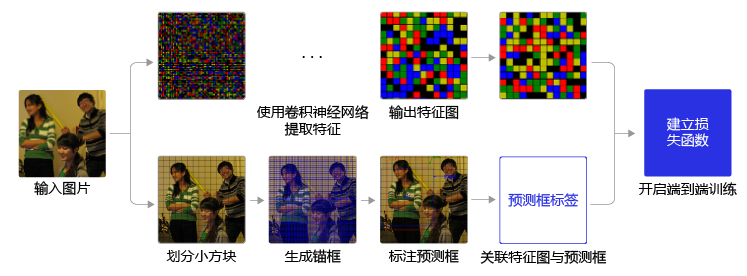

- 左边是输入图片，上半部分所示的过程是使用卷积神经网络对图片提取特征，随着网络不断向前传播，特征图的尺寸越来越小，每个像素点会代表更加抽象的特征模式，直到输出特征图，其尺寸减小为原图的1/32。
- 下半部分描述了生成候选区域的过程，首先将原图划分成多个小方块，每个小方块的大小是32 x 32，然后以每个小方块为中心分别生成一系列锚框，整张图片都会被锚框覆盖到。在每个锚框的基础上产生一个与之对应的预测框，根据锚框和预测框与图片上物体真实框之间的位置关系，对这些预测框进行标注。
- 将上方支路中输出的特征图与下方支路中产生的预测框标签建立关联，创建损失函数，开启端到端的训练过程。

### 产生候选区域

如何产生候选区域，是检测模型的核心设计方案。目前大多数基于卷积神经网络的模型所采用的方式大体如下：
- 按一定的规则在图片上生成一系列位置固定的锚框，将这些锚框看作是可能的候选区域。
- 对锚框是否包含目标物体进行预测，如果包含目标物体，还需要预测所包含物体的类别，以及预测框相对于锚框位置需要调整的幅度。


#### 生成锚框

- 将原始图片划分成m x n个区域，YOLOv3算法会在每个区域的中心，生成一系列锚框。
- 锚框的中心位置和大小是预先设定好的，在模型中可以当作是超参数。

#### 生成预测框

- 锚框的位置是固定好的，不可能刚好与物体的边界重合，需要在锚框的基础上进行位置的微调以生成预测框，预测框相对于锚框会有不同的中心位置和大小。
- 预测框可以看作是在锚框基础上的一个微调，每个锚框会有一个跟它对应的预测框。

#### 对候选区域进行标注

每个区域可以产生3种不同形状的锚框，每个锚框都是一个可能的候选区域，对候选区域进行标注需要确定三个标签的值：
- 锚框是否包含物体 objectness
- 如果锚框包含了物体，那么它对应的预测框的中心位置和大小 location(x, y, w, h)
- 如果锚框包含了物体，那么具体类别是什么 label

### 卷积神经网络提取特征

- 通过连续使用多层卷积和池化等操作，能得到语义含义更加丰富的特征图。
- 在检测问题中，也使用卷积神经网络逐层提取图像特征，通过最终的输出特征图来表征物体位置和类别等信息。
- YOLOv3算法使用的骨干网络是Darknet53，并在骨干网络的基础上，再添加检测相关的网络模块

### 根据输出特征图计算预测框位置和类别

- 建立输出特征图与预测框之间的关联
- 让特征图上的每个像素点分别跟原图上一个小方块区域对应，解决空间位置的对应关系。


特征图与候选区域的关联
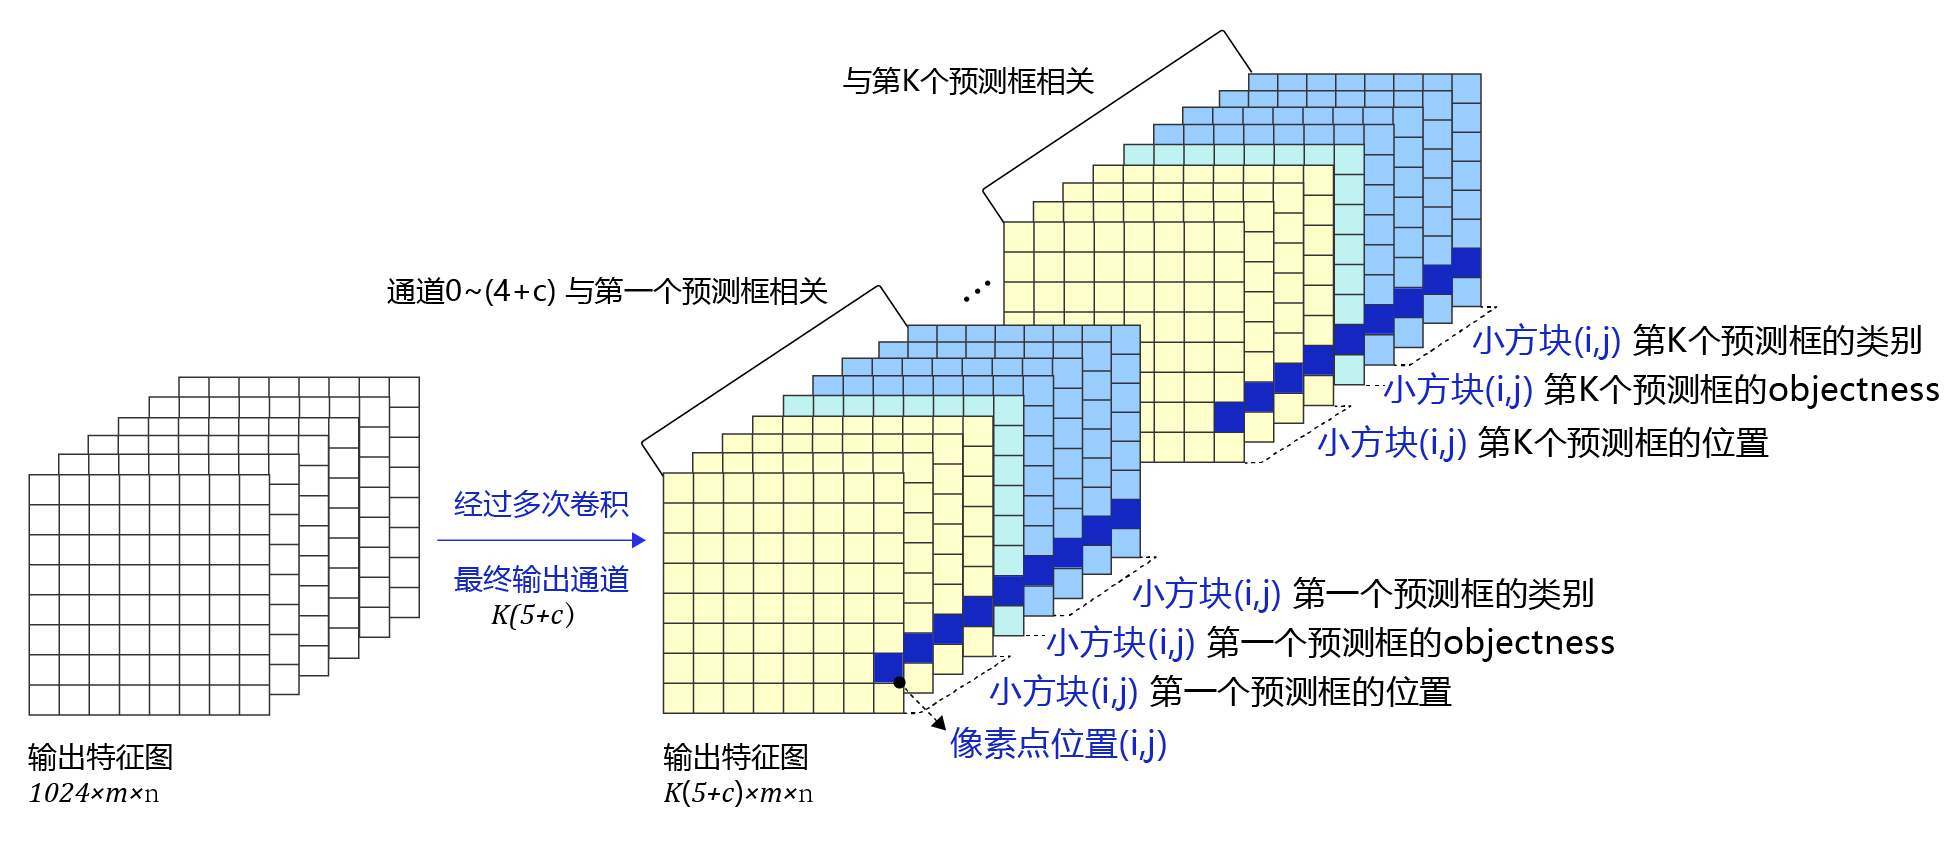

### 损失函数

- 除了从概念上将输出特征图的像素点和预测框关联起来，要对神经网络进行求解，还必须从数学上将网络输出和预测框关联起来，也就是要建立起损失函数跟网络输出之间的关系。
- 对于每个预测框，YOLOv3模型会建立三种类型的损失函数，然后计算总的损失函数
    - 表征是否包含目标物体的损失函数
    - 表征物体位置的目标函数
    - 表征物体类别的损失函数

### 多尺度检测

在目标检测中，将高层级的特征图尺寸放大之后跟低层级的特征图进行融合，得到的新特征图既能包含丰富的语义信息，又具有较多的像素点，能够描述更加精细的结构。

生成多层级的输出特征图
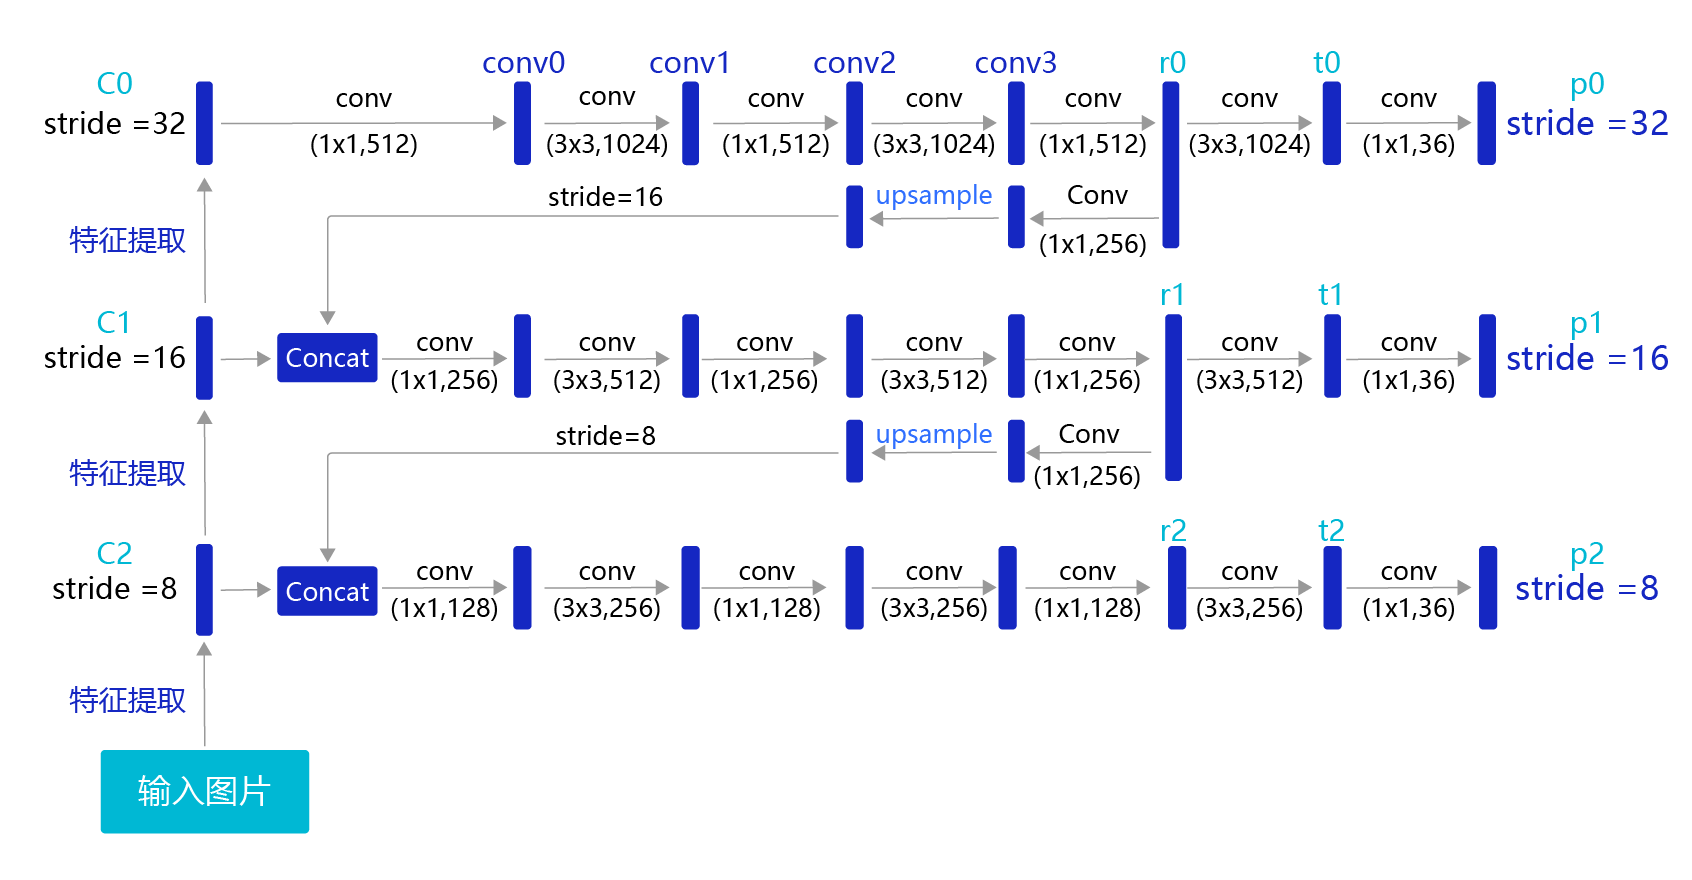

### 开启端到端训练

- 输入图片经过特征提取得到三个层级的输出特征图，相应的分别使用不同大小的小方块区域去生成对应的锚框和预测框，并对这些锚框进行标注。
- 将三个层级的特征图与对应锚框之间的标签关联起来，并建立损失函数，总的损失函数等于三个层级的损失函数相加。通过极小化损失函数，可以开启端到端的训练过程。

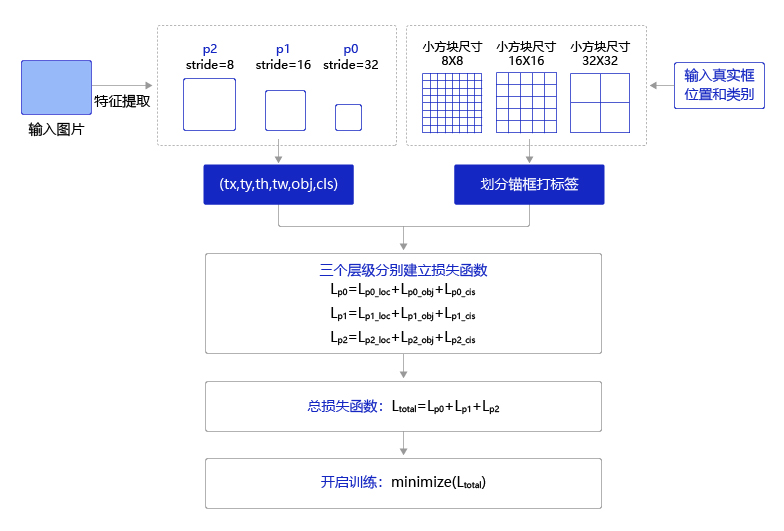

### 预测

预测过程分为两步：
- 通过网络输出计算出预测框位置和所属类别的得分。
- 使用非极大值抑制来消除重叠较大的预测框。

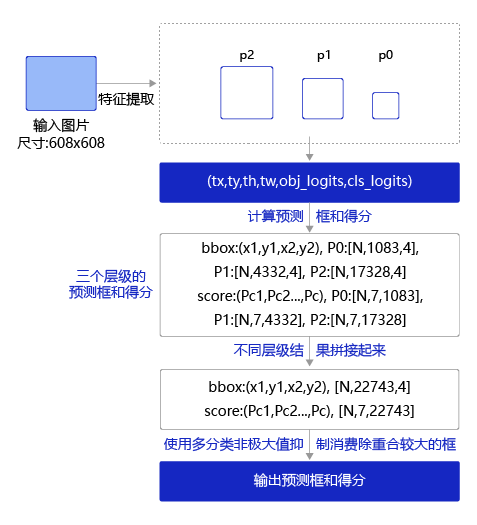